In [36]:
import yfinance as yf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as f
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import  StandardScaler

In [38]:
TICKER = "SOL-USD"
TIME_PERIOD = "7d"
TIME_INTERVAL = "5m"

In [39]:
def GetData(LOOKBACK, dataset_gold, ss):
  dataset_gold['Target'] = dataset_gold['Close']-dataset_gold.Open
  dataset_gold['TargetClass'] = [1 if dataset_gold.Target[i]>0 else 0 for i in range(len(dataset_gold))]

  x = np.reshape(np.array(dataset_gold['Target']), (-1, 1))
  x = np.reshape(ss.fit_transform(x), (-1))


  x_open = dataset_gold['Close'].values[-LOOKBACK:]


  split_len = int(len(x) * 0.8)
  x_train, x_test = x[:split_len],  x[split_len:]

  x_batch = []
  y_batch = []
  x_train_batch, y_train_batch = [], []
  x_test_batch, y_test_batch = [], []


  for i in range(len(x) - LOOKBACK):
    x_batch.append(x[i:LOOKBACK + i])
    y_batch.append(x[LOOKBACK + i])



  x_train_batch, x_test_batch = np.array(x_batch[:split_len]),  np.array(x_batch[split_len:])
  y_train_batch, y_test_batch = np.array(y_batch[:split_len]),  np.array(y_batch[split_len:])


  x_train_batch, y_train_batch = torch.FloatTensor(x_train_batch), torch.FloatTensor(y_train_batch)
  x_test_batch, y_test_batch = torch.FloatTensor(x_test_batch), torch.FloatTensor(y_test_batch)

  return x_open, x_train_batch, x_test_batch, y_train_batch, y_test_batch

In [40]:
LOOKBACK = 200
EPOCHS = 30

dataset_gold = yf.download(tickers = TICKER, period = TIME_PERIOD,  interval = TIME_INTERVAL)
ss = StandardScaler()

x_open, x_train_batch, x_test_batch, y_train_batch, y_test_batch = GetData(LOOKBACK, dataset_gold, ss)


[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_38076/3076644346.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dataset_gold['TargetClass'] = [1 if dataset_gold.Target[i]>0 else 0 for i in range(len(dataset_gold))]


In [41]:
class Stock(nn.Module):
  def __init__(self, lookback):
    super().__init__()
    self.enc_layer1 = nn.TransformerEncoderLayer(d_model=600, nhead=20, batch_first = True)
    self.transformer_encoder1 = nn.TransformerEncoder(self.enc_layer1, num_layers=1)
    self.fc1 = nn.Linear(600, 1)
    self.gcell = nn.GRUCell(600, 600)
    self.gcell1 = nn.GRUCell(lookback, 600)

    self.drop = nn.Dropout(0.2)




  def forward(self, x:torch.Tensor) -> torch.Tensor:
    x = self.gcell1(x).unsqueeze(1)
    x = self.drop(x)
    x = self.transformer_encoder1(x).squeeze()
    x = self.gcell(x)
    x = self.drop(x)
    x = self.fc1(x)

    return x.squeeze(-1)

In [42]:
model = Stock(LOOKBACK)
loss_f = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

data = torch.autograd.Variable(x_train_batch, requires_grad=False)
target = torch.autograd.Variable(y_train_batch, requires_grad=False)

In [43]:
def train(epochs):
  model.train()
  pred = model(data)
  loss = loss_f(pred, target)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  scheduler.step()
  print(f"Epoch: {epochs}, loss = {loss}")

  

In [44]:
for i in range(EPOCHS):
  train(i)

Epoch: 0, loss = 0.9705251455307007
Epoch: 1, loss = 0.8730021715164185
Epoch: 2, loss = 1.9950251579284668
Epoch: 3, loss = 0.7532805800437927
Epoch: 4, loss = 0.9916828274726868
Epoch: 5, loss = 0.7690222263336182
Epoch: 6, loss = 0.9833210706710815
Epoch: 7, loss = 0.7410933971405029
Epoch: 8, loss = 0.6949199438095093
Epoch: 9, loss = 0.7781164646148682
Epoch: 10, loss = 0.6456865072250366
Epoch: 11, loss = 0.5787295699119568
Epoch: 12, loss = 0.594836950302124
Epoch: 13, loss = 0.6078824996948242
Epoch: 14, loss = 0.5579129457473755
Epoch: 15, loss = 0.49922823905944824
Epoch: 16, loss = 0.4809179902076721
Epoch: 17, loss = 0.473245769739151
Epoch: 18, loss = 0.440875381231308
Epoch: 19, loss = 0.3965829610824585
Epoch: 20, loss = 0.3547675907611847
Epoch: 21, loss = 0.32941770553588867
Epoch: 22, loss = 0.31309938430786133
Epoch: 23, loss = 0.290099561214447
Epoch: 24, loss = 0.2594175636768341
Epoch: 25, loss = 0.23030786216259003
Epoch: 26, loss = 0.2073054313659668
Epoch: 27, 

In [45]:
dataset_gold = yf.download(tickers = TICKER, period = TIME_PERIOD,  interval = TIME_INTERVAL)
print()
ss = StandardScaler()

x_open, x_train_batch, x_test_batch, y_train_batch, y_test_batch = GetData(LOOKBACK, dataset_gold, ss)


EPOCHS = 20

data = torch.autograd.Variable(x_train_batch, requires_grad=False)
target = torch.autograd.Variable(y_train_batch, requires_grad=False)
def train(epochs):
  model.train()
  pred = model(data)
  loss = loss_f(pred, target)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  print(f"Epoch: {epochs}, loss = {loss}")


for i in range(EPOCHS):
  train(i)

[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_38076/3076644346.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dataset_gold['TargetClass'] = [1 if dataset_gold.Target[i]>0 else 0 for i in range(len(dataset_gold))]



Epoch: 0, loss = 0.13791954517364502
Epoch: 1, loss = 0.12261322140693665
Epoch: 2, loss = 0.1207188218832016
Epoch: 3, loss = 0.11072871834039688
Epoch: 4, loss = 0.10655087232589722
Epoch: 5, loss = 0.10252890735864639
Epoch: 6, loss = 0.09711717814207077
Epoch: 7, loss = 0.09176322817802429
Epoch: 8, loss = 0.09384626150131226
Epoch: 9, loss = 0.08413182944059372
Epoch: 10, loss = 0.0717240422964096
Epoch: 11, loss = 0.07354982197284698
Epoch: 12, loss = 0.0677027702331543
Epoch: 13, loss = 0.06365004926919937
Epoch: 14, loss = 0.061408162117004395
Epoch: 15, loss = 0.05899558216333389
Epoch: 16, loss = 0.05374755710363388
Epoch: 17, loss = 0.04884616285562515
Epoch: 18, loss = 0.05201840400695801
Epoch: 19, loss = 0.05151068791747093


In [46]:
dataset_gold = yf.download(tickers = TICKER, period = TIME_PERIOD,  interval = TIME_INTERVAL)
print()
ss = StandardScaler()

x_open, x_train_batch, x_test_batch, y_train_batch, y_test_batch = GetData(LOOKBACK, dataset_gold, ss)

[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_38076/3076644346.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dataset_gold['TargetClass'] = [1 if dataset_gold.Target[i]>0 else 0 for i in range(len(dataset_gold))]


[160.98832703] [[0.2600156]]
[161.24834263] [[-0.18509494]]
[161.0632477] [[0.18669702]]
[161.24994472] [[-0.14180055]]
[161.10814416] [[-0.02216599]]
[161.08597818] [[-0.04655584]]
[161.03942234] [[0.19593924]]
[161.23536158] [[-0.22579515]]
[161.00956643] [[0.00051161]]
[161.01007805] [[-0.19179854]]
[160.81827951] [[0.21056235]]
[161.02884186] [[0.16991013]]
[161.19875199] [[0.0601422]]
[161.25889419] [[-0.00658245]]
[161.25231174] [[-0.00845958]]
[161.24385215] [[-0.06955256]]
[161.17429959] [[-0.04722905]]
[161.12707054] [[0.0396107]]
[161.16668124] [[0.04315429]]
[161.20983553] [[-0.07534605]]


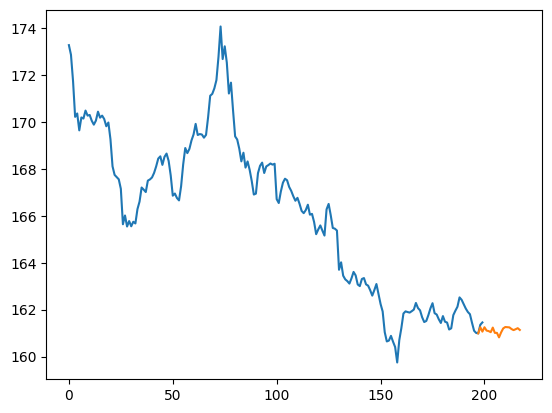

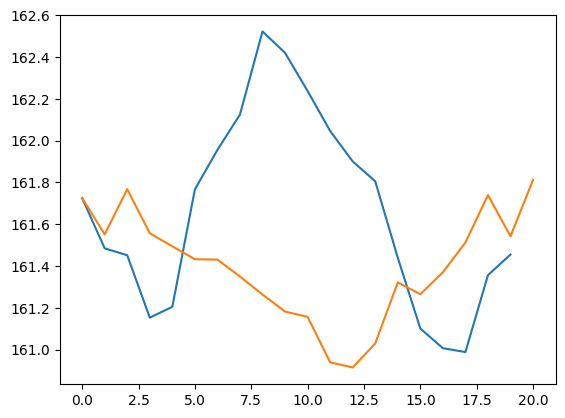

In [47]:
with torch.inference_mode():
  model.eval()

  hist = x_test_batch[-3].numpy()

  preds = []
  preds_open = [x_open[-3]]
  for i in range(20):
    pred1 = ss.inverse_transform(model(torch.from_numpy(hist).unsqueeze(0)).numpy().reshape(-1, 1))
    preds.append(pred1)
    hist = np.roll(hist, -1)
    hist[-1] = pred1.squeeze().squeeze()
    print(preds_open[-1], pred1)
    preds_open.append(preds_open[-1] + pred1.squeeze().squeeze())


  plt.plot(x_open)
  plt.plot(np.arange(len(x_open) - 3, len(x_open) + len(preds_open) - 3, 1), preds_open)
  plt.show()

  x_open = dataset_gold['Close'].values[-100:]

  a = 20
  hist = x_test_batch[-a].numpy()

  preds_open = [x_open[-a]]
  for i in range(20):
    pred1 = ss.inverse_transform(model(torch.from_numpy(hist).unsqueeze(0)).numpy().reshape(-1, 1))
    hist = np.roll(hist, -1)
    hist[-1] = pred1.squeeze().squeeze()
    preds_open.append(preds_open[-1] + pred1.squeeze().squeeze())


  plt.show()
  plt.plot(x_open[-a:])
  plt.plot(preds_open)
